In [2]:
import cv2
import numpy as np
import math

# 分光情報処理のために読み込む
# conda install -c conda-forge colour-science
# https://github.com/colour-science/Colour/
import colour
from colour.plotting import *

import matplotlib.pyplot as plt
%matplotlib inline

[192, 108]


True

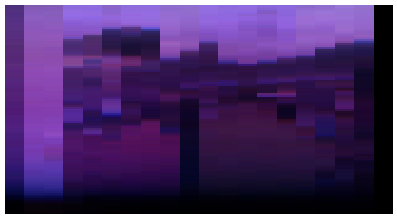

In [13]:
# 撮影モードは、Landscape前提、としておく
# つまり、波長方向は w 方向
# 画像の空間(h)方向は h 方向
# カメラの向きが、空間(w)方向

# 処理設定
# 動画をファイルから読み込むか、カメラから読み込むかを決める
isCamera = False
# 画像ファイルを保存するか
isFileSave = False

# 逐次処理中に分光画像生成を行うか
isCreateSpectrumImage = True

# 横位置として、780-1300 px がスペクトル部分
# デバイスが撮影するだろう画像サイズ（記入値はiPhone 11 の場合）
assumptionW = 1920
assumptionH = 1080

# デバイスが撮影するだろう画像サイズ下で、
# 分光情報が得られるだろうX位置・領域 (これも想定)
spectorPixelStart = 800
spectorPixelWidth = 1300-780 # ⇒520

#-----------縮尺比率を決める-----------------------
# 撮影画像を（計算時間短縮のために）長さで何分の一にするかを決める
compressionRatioInLength = 10  # 10分の1

#-----------縮尺比率にしたがったピクセルサイズを決める-----------------------
# a as assumption
aW = int( assumptionW / compressionRatioInLength ) # a as assumption
aH = int( assumptionH / compressionRatioInLength )

print([aW, aH])
aSpectorPixelWidth = int(spectorPixelWidth / compressionRatioInLength)
aSpectorPixelStart = int(spectorPixelStart / compressionRatioInLength)

# 単純化したRGB値をどの（x方向）画素から読み込むか
aBOffset = int(aSpectorPixelWidth/6)
aGOffset = int(3*aSpectorPixelWidth/6)
aROffset = int(5*aSpectorPixelWidth/6)

# 処理するピクセル数を決める
def normalDist(x,  mu = 0, sigma = 1):
    return np.exp( - ( x - mu )**2 / ( 2 * sigma**2 ) )

gg = np.array( [ ( 0.2 + normalDist( x, 40, 12 ) ) / 1.2 for x in np.linspace( 0, 99, aSpectorPixelWidth ) ] )
rg = np.array( [ ( 0.2 + normalDist( x, 65, 7 ) )    / 1.2 for x in np.linspace( 0, 99, aSpectorPixelWidth ) ] )

# 波長 420nmから730nmまでの分光スペクトルを、
# RGB素子に撮像されたRGB画像配列から、下記としてフィッティングする
def slice2spec( slice ):
    b = np.array( [ x**2.2 * 255 for x in slice[ ::1, 0 ] / 255 ] )
    g = np.array( [ x**2.2 * 255 for x in slice[ ::1, 1 ] / 255 ] )
    r = np.array(  [ x**2.2 * 255 for x in slice[ ::1, 2 ] / 255 ] ) 
    return 1.6 * b + 1.5 * g/gg + 0.7 * r/rg

# 波長リスト
wl = np.linspace( 420, 730, aSpectorPixelWidth )

# ------------撮影時の歪み補正用の行列を生成する------------
# 画像サイズや歪み程度が一定なら、動画読み込みより事前に処理しておく
#m1 = 0.1 # ずれ補正の傾斜調整、1 より小さな値に設定する、0になると補正量は0になる
m2 = int(-45.0/compressionRatioInLength) #  中央と上下両端での、横方向ズレをピクセルで表したもの
mapY = np.zeros( (aH, aW), dtype=np.float32 ) 
mapX = np.zeros( (aH, aW), dtype=np.float32 )
for y in range( aH ): 
    mapY[y, :] = y # Y方向は変化させない
for y in range( aH ): 
    for x in range( aW ): 
        mapX[y, x] = x + m2 * math.cos( (float(y)-float(aH)/2.0) / (float(aH)/2.0) * math.pi/2.0 )
#cv2.imwrite( 'mapX.png', mapX )

#-----------動画デバイスを開く(撮影ループ)-----------------------
if isCamera: # カメラから動画を読み込む場合
    cap = cv2.VideoCapture(1)
    # カメラの場合は「読み込む時間長さ（フレーム数）」を決めておく
    frame_n = 25*10 # フレームレート(frame/sec) * 撮影時間(sec.)
else:           # ファイルから動画を読み込む場合
    cap = cv2.VideoCapture("21DA6494-D711-4C74-AD92-85CD4AAC028B.MOV")
    frame_n = round( cap.get(cv2.CAP_PROP_FRAME_COUNT) )
if not cap.isOpened(): # 動画ファイルを開くことができなかったら
    exit()

# 画像サイズを取得する
w = round( cap.get( cv2.CAP_PROP_FRAME_WIDTH ) )
h  = round( cap.get( cv2.CAP_PROP_FRAME_HEIGHT ) )

# RGB3チャンネル画像格納用行列を作成する
simpleRGBImg = np.zeros( ( aH, int(frame_n/compressionRatioInLength)+1, 3 ), np.float )

# 2次元分光画像行列を作成する
spectorImg = [] 

# 動画読み取りループ
n = 0
while( True ):
    ret, frame = cap.read()  # 動画象読み取り

    # 各種終了処理
    if not ret: # 画像を読み取れなかった場合
        break
    if ( (cv2.waitKey(1) & 0xFF == ord('q')) ): # OpenCV Windowで q を押すと終了（しちゃう）
        break

    frame = cv2.resize(frame , (aW, aH) )

    undistortFrame = cv2.remap( frame, mapX, mapY, cv2.INTER_CUBIC)
    # 歪み補正や位置確認のために1枚目をファイル保存する場合
    if n==0 and isFileSave:
        cv2.imwrite('frame.png', frame)
        cv2.imwrite('undistortFrame.png', undistortFrame)

    #JupyterでOpenCVを使うときにdestroyAllWindows()すると固まってしまう
    #https://qiita.com/kemako/items/fd72c65ca964a1b74fef
    cv2.startWindowThread()
    cv2.imshow('frame', undistortFrame)     
    #cv2.imshow('frame', frame)     
    
    # 簡易ＲＧＢ画像出力
    if n % compressionRatioInLength == 0:
        simpleRGBImg[ :, int(n/compressionRatioInLength), 0 ] = frame[ :, aSpectorPixelStart + aROffset, 2 ].astype( np.float ) # R
        simpleRGBImg[ :, int(n/compressionRatioInLength), 1 ] = frame[ :, aSpectorPixelStart + aGOffset, 1 ].astype( np.float ) # G
        simpleRGBImg[ :, int(n/compressionRatioInLength), 2 ] = frame[ :, aSpectorPixelStart + aBOffset,0 ].astype( np.float ) # B
    
    # -----スペクトル列作成＆スペクトル画像に追加----------
    if isCreateSpectrumImage and n % compressionRatioInLength == 0:
        spectorSlice = []
        for y in range( 0, aH, 1 ):
            spector = frame[  y,  
                    aSpectorPixelStart : aSpectorPixelStart+aSpectorPixelWidth, 
                    : ].astype( np.float )
            powData = slice2spec( spector )  
            WLvsPow =  dict( zip ( wl, powData ) ) # 波長：強度　の辞書リストを作る
            sdm = colour.SpectralDistribution(WLvsPow, name='sdm')
            spectorSlice.append( sdm )
        spectorImg.append( spectorSlice )

    n = n+1
    if n >=  frame_n:
        break

cap.release()                     # 動画象読み取り終了
cv2.waitKey(1)
cv2.destroyAllWindows()   # 動画象表示終了
cv2.waitKey(1)

# 簡易 RGB 画像の表示
plt.figure( figsize=(10, 40), dpi=50 )
plt.axis("off")
plt.imshow( simpleRGBImg/255, aspect=0.1 )
cv2.imwrite( 'simpleRGBImg.png', simpleRGBImg )

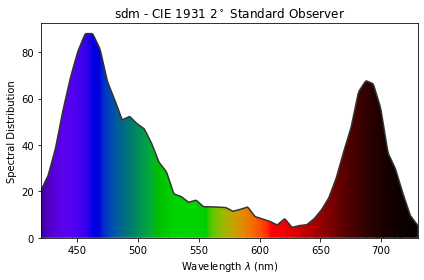

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x132dfd4810>)

In [16]:
sd_copy = spectorImg[10][50].copy()

# Interpolating the copied sample spectral distribution.
sd_copy.interpolate( colour.SpectralShape(420, 730, 10) )
colour.XYZ_to_sRGB( colour.sd_to_XYZ( sd_copy )/100.0 )

plot_single_sd( spectorImg[0][0] )

True

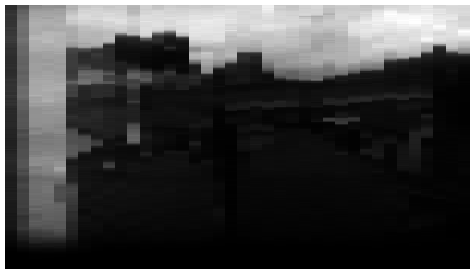

In [37]:
img500 = np.array([
   [ spector.copy().interpolate( 
    colour.SpectralShape(420, 730, 
                         10 # 波長ステップ
                        ) )[ 500 ]
       for spector in spectorSlice
   ] for spectorSlice in spectorImg
])

plt.figure( figsize=(12, 16), dpi=50 )
plt.axis('off')
plt.imshow(  cv2.flip(cv2.rotate(img500, cv2.ROTATE_90_CLOCKWISE), 1)/np.max(  img500 ),
           aspect=0.1,  cmap='gray')

cv2.imwrite('img500.tiff', img500/np.max(  img500 ) )